## PRACTICA OBLIGATORIA: **DBSCAN y Clustering Jerárquico**

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc

### Parte I. Modelado

#### Descripción del problema.

Una empresa dedicada al desarrollo de bebidas energéticas está experimentando con distintas combinaciones de ingredientes para crear nuevas variantes de su producto principal, **“NonstopU”**.

La fabricación de cada prototipo requiere tiempo y recursos, y las pruebas posteriores —tanto de sabor como de efectos estimulantes (antifatiga y antisueño)— resultan costosas.

Por este motivo, la empresa desea **segmentar previamente las mezclas únicamente a partir de las cantidades de sus componentes**, sin necesidad de producirlas ni probarlas físicamente.

Disponen de un conjunto de datos históricos con composiciones de mezclas anteriores. Sin embargo:

* No se realizaron pruebas con usuarios.
* No existen variables objetivo relacionadas con preferencia, eficacia o nivel antifatiga.
* No se dispone, por tanto, de una etiqueta que permita aplicar un modelo supervisado clásico.

La empresa solicita el desarrollo de un **modelo de segmentación no supervisada** que permita agrupar las posibles bebidas según similitudes en su composición química. Posteriormente, el equipo químico se encargará de interpretar los grupos obtenidos.

Adicionalmente, sería deseable analizar si existe algún tipo de relación o proximidad entre los distintos segmentos (por ejemplo, qué grupos se parecen más entre sí).

---

### Información adicional

* **Nota orientativa:** Se estima que el número razonable de segmentos estará entre **3 y 5**.
* **Nota operativa:** El conjunto de datos proporcionado se encuentra en:
  `./data/empowering_drinks.csv`

---

### Se pide

1. Implementar **al menos dos algoritmos de clustering**, siendo obligatorio:

   * **DBSCAN**
   * Otro algoritmo adecuado al problema (cuya elección debe justificarse en función del contexto).

2. Comparar brevemente los resultados obtenidos por ambos modelos, aunque sea de forma especulativa.
   (Se deberá justificar por qué la comparación tiene carácter especulativo.)

---

### Se recomienda

* Realizar visualizaciones exploratorias de las variables dos a dos para identificar relaciones relevantes.
* No es obligatorio utilizar todas las variables.
* No es obligatorio limitarse a dos variables.
* Probar distintos hiperparámetros teniendo en cuenta la estimación de entre 3 y 5 segmentos.
* Justificar la elección final de hiperparámetros.

---

### Proceso sugerido

Seguir una metodología similar a la trabajada anteriormente en problemas de aprendizaje automático:

1. Comprensión del problema.
2. Carga y visualización inicial de los datos.
3. Mini-EDA y selección de variables.
4. Tratamiento y transformación de variables.
5. Selección de modelos e hiperparámetros.
6. Entrenamiento y visualización de resultados.
7. Discusión e interpretación de los resultados.


In [2]:
df = pd.read_csv("./data/empowering_drinks.csv", sep="|")

display(df.sample(10))

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
64,-0.976623,-2.253579,-0.752242,-0.092010,-0.955153
151,1.395086,1.365208,-1.274305,-0.595160,1.791666
67,0.604516,-0.462462,-0.190020,-0.875396,-0.570166
95,-0.717217,-0.352802,-0.190020,-1.375361,-1.020039
120,-0.198406,0.890014,-1.434939,-0.499626,-0.059734
142,0.715690,1.182441,-1.193987,0.009893,1.558078
148,0.493343,0.414820,-1.284344,0.009893,0.969783
141,-0.223111,-0.243142,-1.374701,-0.197099,2.250190
137,-0.186053,0.780354,-1.434939,-0.563315,0.225763
43,1.703902,-0.316249,1.145255,1.013009,-0.068385


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB
None


In [4]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Azúcares,153.0,0.019231,1.026182,-2.434235,-0.816038,0.061000,0.876275,2.259772
Vitamínas del grupo B,153.0,0.037273,0.995984,-3.679162,-0.499016,-0.023821,0.707247,3.156325
Cafeína,153.0,0.041057,1.040928,-1.695971,-1.043392,0.211566,0.894264,3.062832
Ácido Cítrico,153.0,0.080022,1.009450,-1.493188,-0.738463,-0.165254,0.917474,2.971473
Taurina,153.0,-0.044088,0.934399,-1.634288,-0.799428,-0.154899,0.493956,2.431870


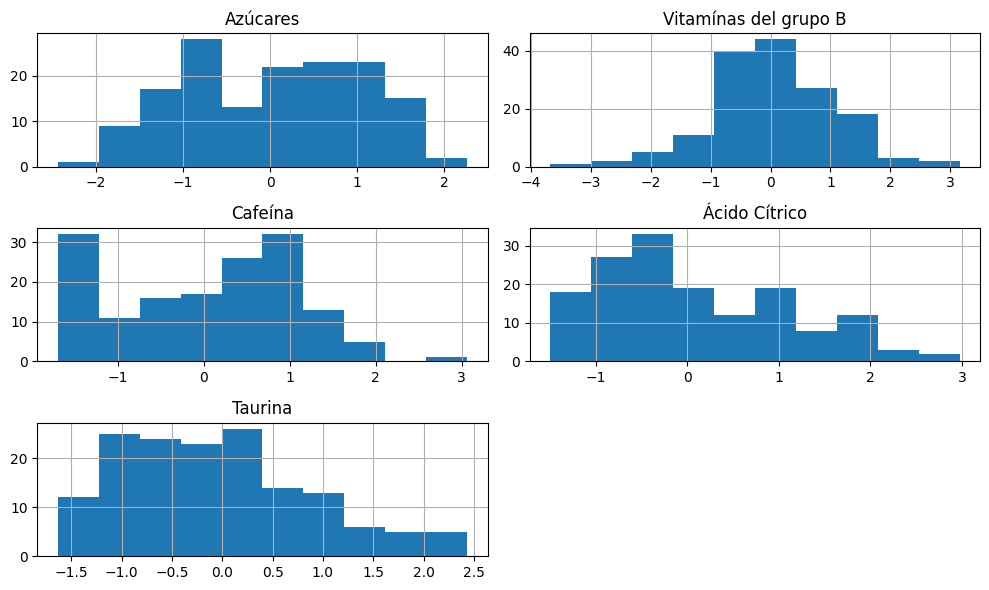

In [5]:
#Observación de distribuciones

df.hist(figsize=(10,6))
plt.tight_layout()
plt.show()


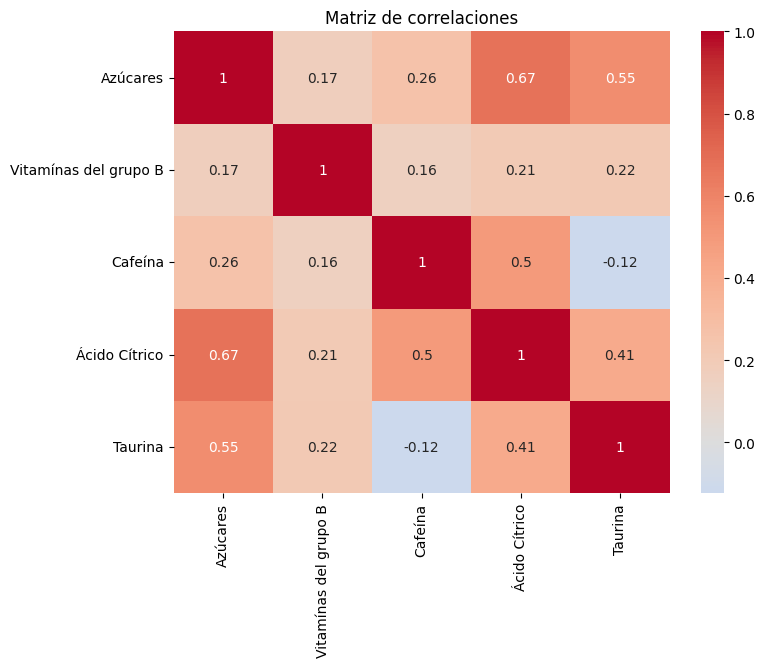

In [6]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlaciones")
plt.show()


Con la matriz de correlaciones podemos observar que la relación lineal entre las variables es poco clara, cada variable aporta una información relativamente distinta. 

Si dos de ellas hubieran tenido una correlación muy alta, estarían contando casi lo mismo y podrían, en clustering, distorsionar las distancias.

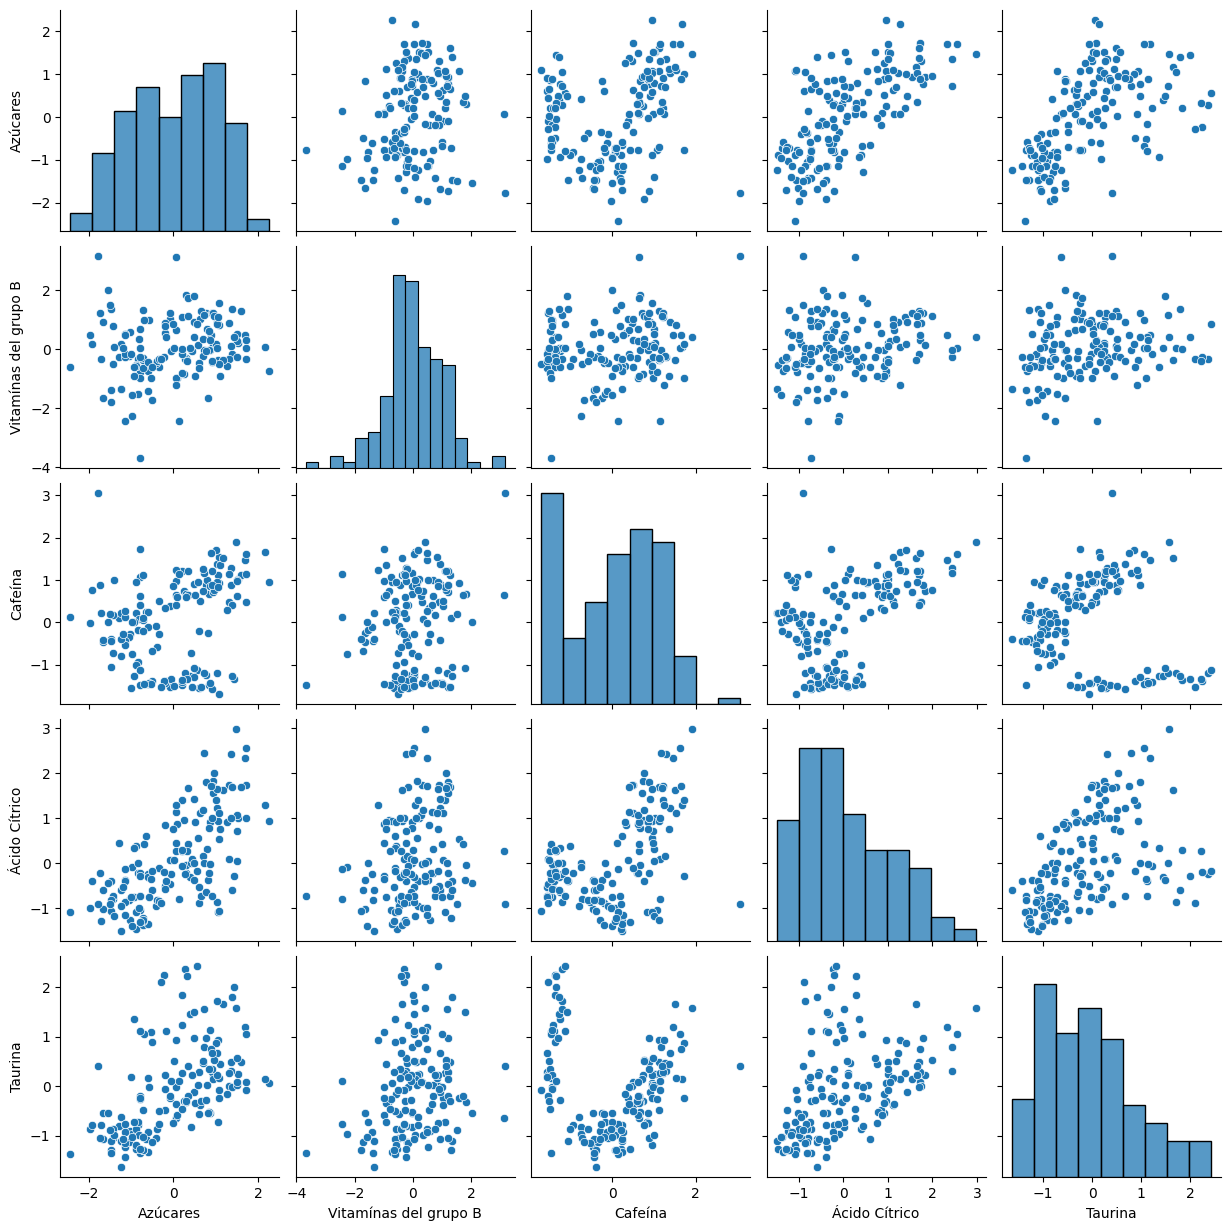

In [7]:
sns.pairplot(df)
plt.show()

Tratamiento de features:

Según las medias y las desviaciones ( media ≈ 0 y std ≈ 1, respectivamente), las features están estandarizadas. Pero, por seguridad, haremos escalado para que se aproximen aún más a dichos valores.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

X_scaled = pd.DataFrame(X_scaled, columns=df.columns)

X_scaled.describe().T


,count,mean,std,min,25%,50%,75%,max
Azúcares,153.0,-4.644070e-17,1.003284,-2.398720,-0.816631,0.040837,0.837920,2.190546
Vitamínas del grupo B,153.0,2.902544e-17,1.003284,-3.743677,-0.540220,-0.061543,0.674884,3.141914
Cafeína,153.0,4.644070e-17,1.003284,-1.674210,-1.045232,0.164343,0.822351,2.912496
Ácido Cítrico,153.0,0.000000e+00,1.003284,-1.563600,-0.813485,-0.243777,0.832337,2.873790
Taurina,153.0,-1.161018e-17,1.003284,-1.707432,-0.811025,-0.118980,0.577709,2.658488


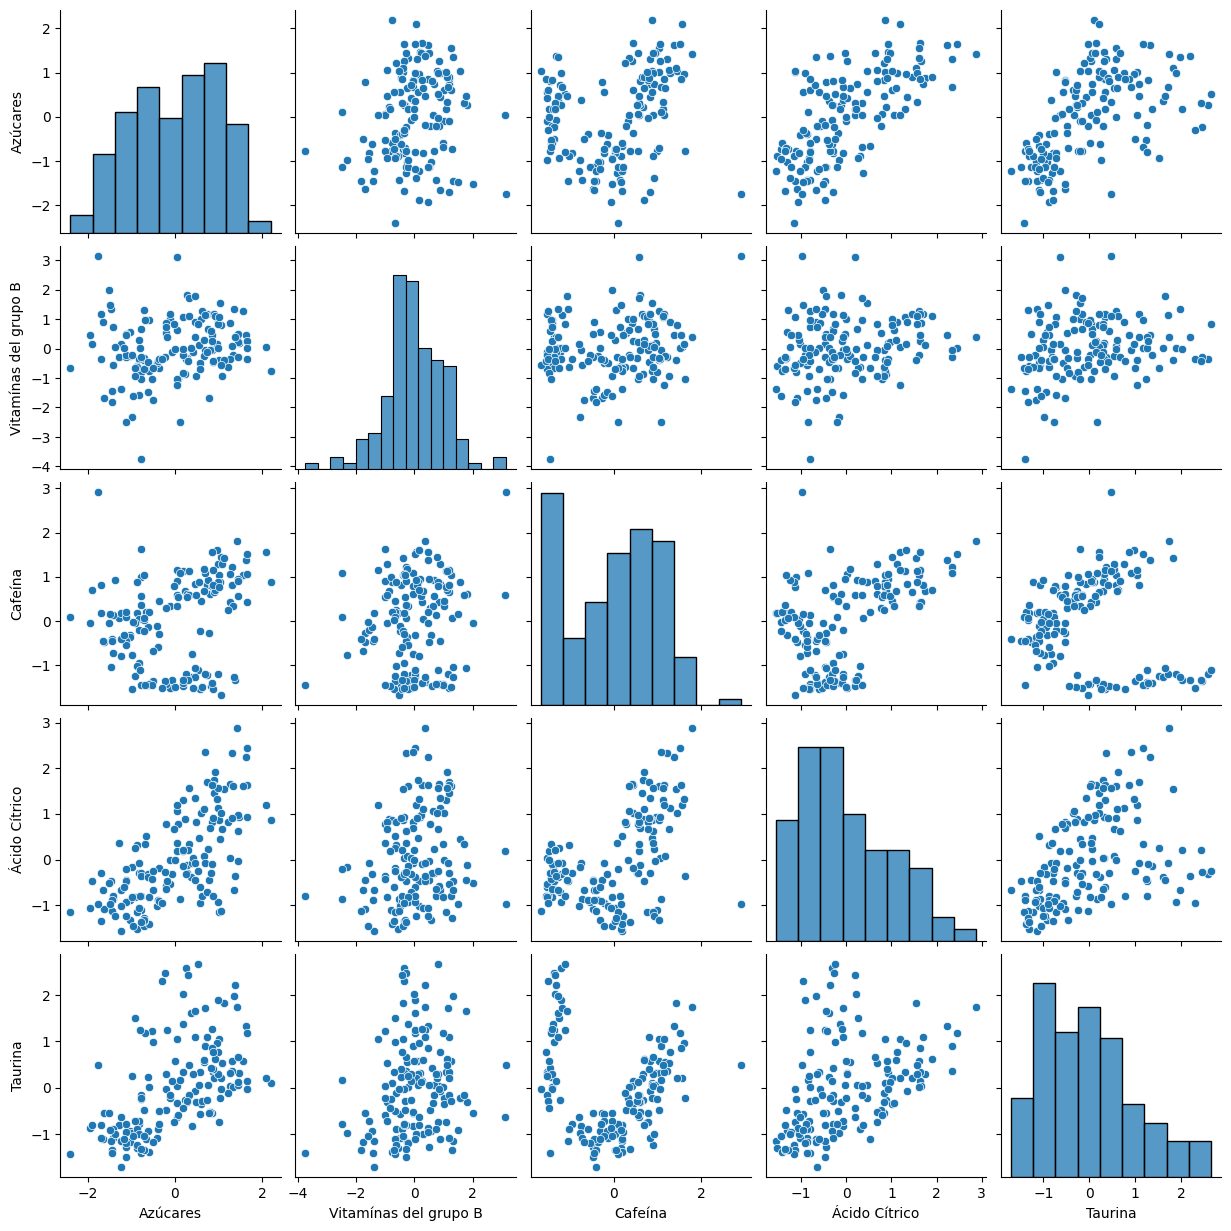

In [9]:
sns.pairplot(X_scaled)
plt.show()

Las agrupaciones más claras entre variables podrían ser las de (por orden de mayor a menor claridad):

- Cafeína vs Taurina
- Cafeína vs Ácido Cítrico
- Cafeína vs Azúcares

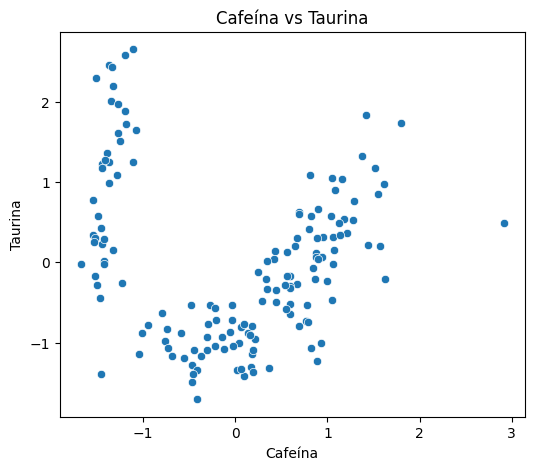

In [10]:
plt.figure(figsize=(6,5))
sns.scatterplot(x="Cafeína", y="Taurina", data=X_scaled)
plt.title("Cafeína vs Taurina")
plt.show()


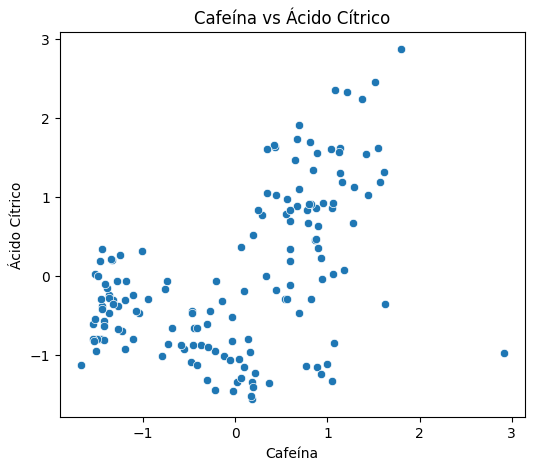

In [11]:
plt.figure(figsize=(6,5))
sns.scatterplot(x="Cafeína", y="Ácido Cítrico", data=X_scaled)
plt.title("Cafeína vs Ácido Cítrico")
plt.show()


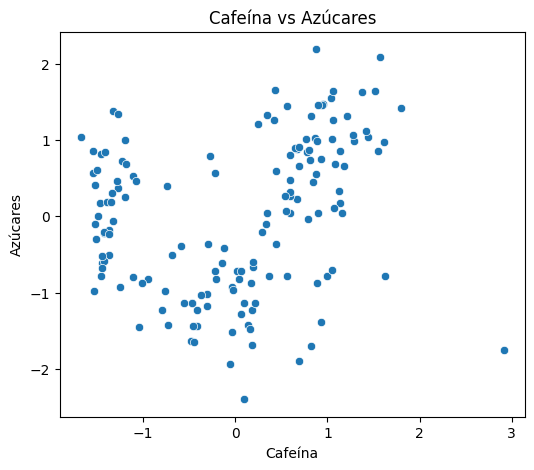

In [12]:
plt.figure(figsize=(6,5))
sns.scatterplot(x="Cafeína", y="Azúcares", data=X_scaled)
plt.title("Cafeína vs Azúcares")
plt.show()


Al ser Cafeína vs Taurina la agrupación más clara, me voy a centrar, de momento en ella.

In [13]:
X_2d = X_scaled[["Cafeína", "Taurina"]]


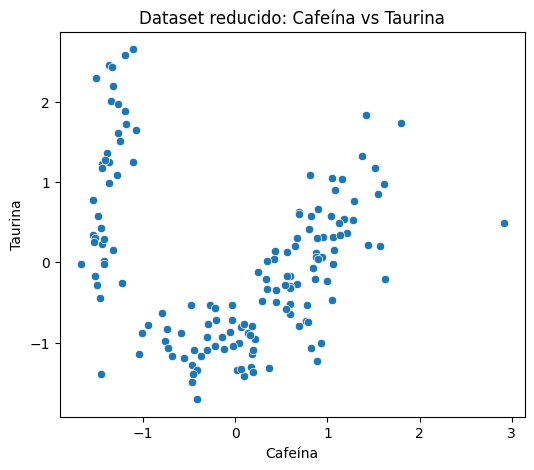

In [14]:
plt.figure(figsize=(6,5))
sns.scatterplot(x="Cafeína", y="Taurina", data=X_2d)
plt.title("Dataset reducido: Cafeína vs Taurina")
plt.show()


Se podrían distinguir entre 3 o 4 grupos. Intentaremos ajustar eps para que detecte de 3 a 5 clusters (como piden los químicos) e intente detectar outliers 

In [15]:
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(X_2d)


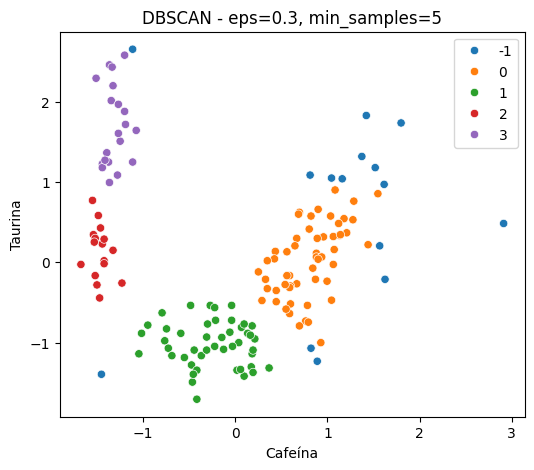

In [16]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_2d["Cafeína"],
    y=X_2d["Taurina"],
    hue=labels,
    palette="tab10"
)

plt.title("DBSCAN - eps=0.3, min_samples=5")
plt.show()


In [17]:
print(np.unique(labels))
#Hemos podido detectar las anomalías (-1) y los grupos (0-3)

len(set(labels)) - (1 if -1 in labels else 0)

[-1  0  1  2  3]


4

In [18]:
#Vamos a comprobar cuántos puntos hay en cada cluster y cuántos son ruido
pd.Series(labels).value_counts()


 0    56
 1    46
 3    20
 2    16
-1    15
Name: count, dtype: int64

Comprobamos el impacto de eps siendo más pequeño y más grande que 0.3 

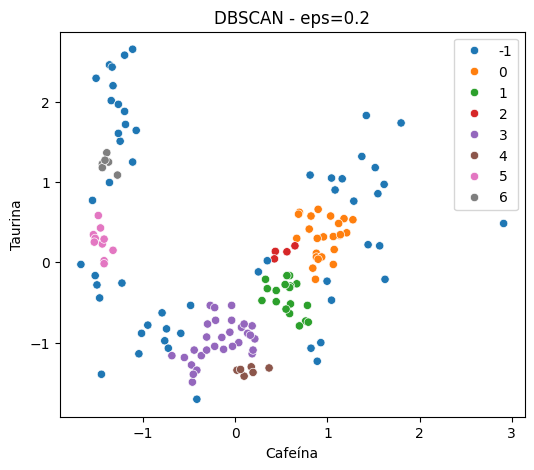

Clusters: 7


In [19]:
dbscan_small = DBSCAN(eps=0.2, min_samples=5)
labels_small = dbscan_small.fit_predict(X_2d)

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_2d["Cafeína"],
    y=X_2d["Taurina"],
    hue=labels_small,
    palette="tab10"
)
plt.title("DBSCAN - eps=0.2")
plt.show()

print("Clusters:", len(set(labels_small)) - (1 if -1 in labels_small else 0))


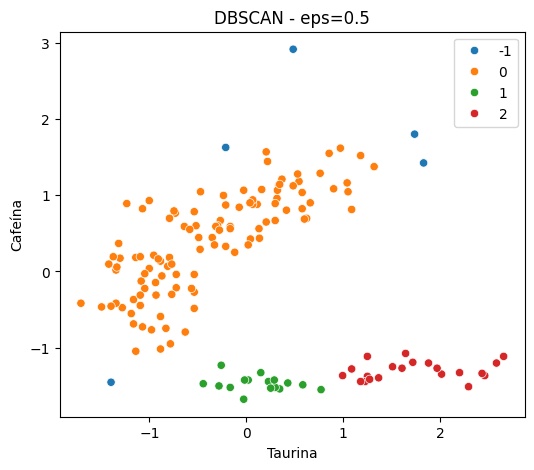

Clusters: 3


In [20]:
dbscan_big = DBSCAN(eps=0.4, min_samples=5)
labels_big = dbscan_big.fit_predict(X_2d)

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_2d["Taurina"],
    y=X_2d["Cafeína"],
    hue=labels_big,
    palette="tab10"
)
plt.title("DBSCAN - eps=0.5")
plt.show()

print("Clusters:", len(set(labels_big)) - (1 if -1 in labels_big else 0))


Con eps = 0.2 se detectan 7 clusters y muchísimo ruido (sobresegmentación).

Con eps = 0.3, 4 clusters, ruido razonable. Se detectan bien las zonas densas sin fragmentarlas demasiado.

Eps = 04. 3 clústers y muy poco ruido. Algunas zonas que antes eran 4 ahora se fusionan en 3.

In [21]:
for m in [3,4,5,6,8]:
    db = DBSCAN(eps=0.3, min_samples=m)
    labels_test = db.fit_predict(X_2d)
    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    print(f"min_samples={m} → clusters={n_clusters}")


min_samples=3 → clusters=3
min_samples=4 → clusters=4
min_samples=5 → clusters=4
min_samples=6 → clusters=5
min_samples=8 → clusters=4


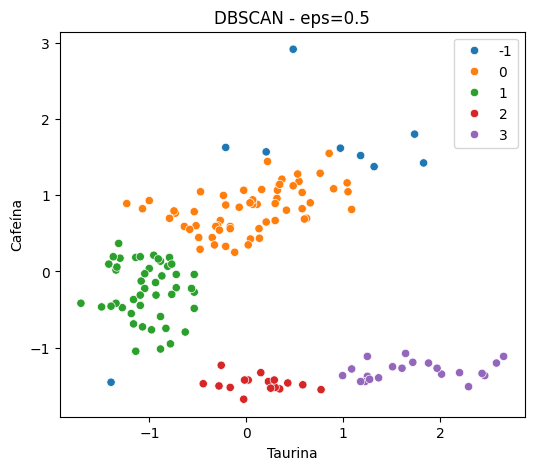

Clusters: 4


In [22]:
dbscan_big = DBSCAN(eps=0.3, min_samples=4)
labels_big = dbscan_big.fit_predict(X_2d)

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_2d["Taurina"],
    y=X_2d["Cafeína"],
    hue=labels_big,
    palette="tab10"
)
plt.title("DBSCAN - eps=0.5")
plt.show()

print("Clusters:", len(set(labels_big)) - (1 if -1 in labels_big else 0))

Tras probar distintos valores de eps y min_samples, se seleccionó eps=0.3 y min_samples=4 al proporcionar una segmentación en cuatro grupos claramente diferenciados, con una cantidad moderada de ruido y coherente con la estructura visual observada en el plano Taurina-Cafeína.

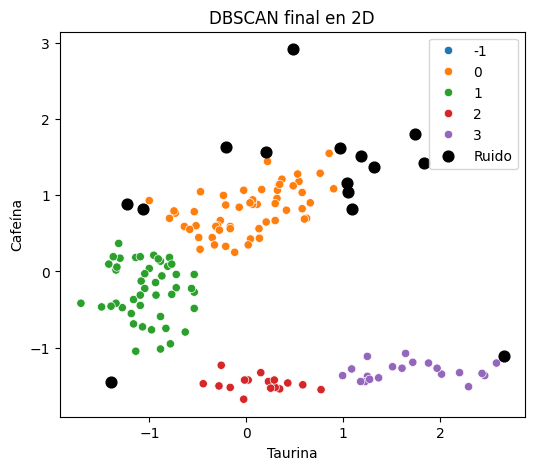

In [23]:
plt.figure(figsize=(6,5))

sns.scatterplot(
    x=X_2d["Taurina"],
    y=X_2d["Cafeína"],
    hue=labels,
    palette="tab10"
)

# Marcar ruido en negro
noise = labels == -1
plt.scatter(
    X_2d.loc[noise, "Taurina"],
    X_2d.loc[noise, "Cafeína"],
    color="black",
    s=60,
    label="Ruido"
)

plt.title("DBSCAN final en 2D")
plt.legend()
plt.show()


In [24]:
dbscan_full = DBSCAN(eps=0.8, min_samples=5)
labels_full = dbscan_full.fit_predict(X_scaled)

print("Clusters:", len(set(labels_full)) - (1 if -1 in labels_full else 0))
pd.Series(labels_full).value_counts()


Clusters: 7


-1    85
 3    20
 1    18
 0    10
 6     6
 2     5
 5     5
 4     4
Name: count, dtype: int64

In [25]:
dbscan_full = DBSCAN(eps=0.6, min_samples=5)
labels_full = dbscan_full.fit_predict(X_scaled)

print("Clusters:", len(set(labels_full)) - (1 if -1 in labels_full else 0))
pd.Series(labels_full).value_counts()

Clusters: 2


-1    139
 0      8
 1      6
Name: count, dtype: int64

In [26]:
dbscan_full = DBSCAN(eps=0.7, min_samples=5)
labels_full = dbscan_full.fit_predict(X_scaled)

print("Clusters:", len(set(labels_full)) - (1 if -1 in labels_full else 0))
pd.Series(labels_full).value_counts()

Clusters: 3


-1    123
 2     15
 1     10
 0      5
Name: count, dtype: int64

In [32]:
dbscan_full = DBSCAN(eps=0.7, min_samples=6)
labels_full = dbscan_full.fit_predict(X_scaled)

print("Clusters:", len(set(labels_full)) - (1 if -1 in labels_full else 0))
pd.Series(labels_full).value_counts()

Clusters: 2


-1    133
 1     14
 0      6
Name: count, dtype: int64

In [38]:
dbscan_full = DBSCAN(eps=0.8, min_samples=6)
labels_full = dbscan_full.fit_predict(X_scaled)

print("Clusters:", len(set(labels_full)) - (1 if -1 in labels_full else 0))
pd.Series(labels_full).value_counts()


Clusters: 4


-1    105
 2     18
 0     15
 1      9
 3      6
Name: count, dtype: int64

El cambio de dimensionalidad ha cambiado el comportamiento de DBSCAN. Las distancias medias entre puntos han aumentado y es más difícil que haya suficientes vecinos dentro de un radio pequeño.
(La maldición de la dimensionalidad)



In [ ]:
#Calculamos la distancia media entre puntos
from sklearn.metrics import pairwise_distances

dist_matrix = pairwise_distances(X_scaled)
print("Distancia media:", dist_matrix.mean())
print("Distancia máxima:", dist_matrix.max())


Distancia media: 2.9471282726575314
Distancia máxima: 8.425127377595402


In [40]:
for eps in [0.8, 1.0, 1.2, 1.5, 2.0]:
    db = DBSCAN(eps=eps, min_samples=5)
    labels_test = db.fit_predict(X_scaled)
    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise = list(labels_test).count(-1)
    print(f"eps={eps} → clusters={n_clusters}, ruido={n_noise}")


eps=0.8 → clusters=7, ruido=85
eps=1.0 → clusters=3, ruido=33
eps=1.2 → clusters=1, ruido=7
eps=1.5 → clusters=1, ruido=4
eps=2.0 → clusters=1, ruido=1


Con eps = 1.0, llegamos a obtener 3 clústers y 33 de ruido (21% de ruido).

Vamos a visualizarlo:

In [47]:
dbscan_full = DBSCAN(eps=1.0, min_samples=5)
labels_full = dbscan_full.fit_predict(X_scaled)
pd.Series(labels_full).value_counts()


 0    49
 1    41
-1    33
 2    30
Name: count, dtype: int64

### Parte II. Nuevos experimentos

El equipo de químicos, satisfecho con los modelos desarrollados, ha generado una nueva serie de mezclas experimentales y solicita su segmentación automática.

Utiliza **uno de los modelos de clustering previamente entrenados** —el que resulte más sencillo o adecuado— para asignar cada nueva mezcla a uno de los segmentos identificados.

Los datos correspondientes a estos nuevos experimentos se encuentran en:
`./data/new_experiments.csv`


### Parte III. EXTRA (Voluntario): 6 meses después...

Gracias a los resultados obtenidos, la unidad de experimentación recibió financiación adicional y pudo realizar pruebas con usuarios.

A partir de estas pruebas, cada bebida ha sido clasificada según su nivel de “energización” en tres categorías:

* **1** → media
* **2** → media-alta
* **3** → alta

Los resultados se encuentran en el archivo correspondiente dentro del directorio `data`. Este fichero está alineado:

* Primero con los experimentos originales.
* A continuación, con los nuevos experimentos clasificados en el apartado anterior.

Se solicita **evaluar la calidad de la segmentación obtenida en la primera parte**, utilizando ahora esta información adicional como referencia externa.